In [31]:
from DataUtils import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

In [32]:
class SensorReader:
    def __init__(self, radiusOfEarth, encoder_resolution, encoder_diameterL, encoder_diameterR):
        self.data_interface = DataInterface(
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv"
        )
        # data -> (lon,lat,alt,left,right,yaw,pitch,roll)
        self.R = radiusOfEarth
        self.res = encoder_resolution
        self.angle_to_rad = np.pi/180
        self.enc_radL = encoder_diameterL / 2
        self.enc_radR = encoder_diameterR / 2
        
        self.init_data = self.parse(self.data_interface.read())
        self.meas = self.init_data.copy()
        self.meas[0:5] = 0 #re-init
        
    def parse(self, data):
        gps = data['gps_data']
        imu = data['imu_data']
        enc = data['encoders_data']
        lat,lon,alt = gps[1:4]
        pitch, roll, yaw = imu[5:8]
        left,right = enc[1:3]
        
        lat = lat*np.pi/180*self.R
        lon = lon*np.pi/180*self.R
        left = left * 2*np.pi/self.res * self.enc_radL
        right = right * 2*np.pi/self.res * self.enc_radR
        
        #pitch = pitch * np.pi / 180
        #yaw = yaw * np.pi / 180
        #roll = roll * np.pi / 180
        
        return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
    def read(self):
        self.meas = self.parse(self.data_interface.read())
        self.meas[0:5] -= self.init_data[0:5]
        return self.meas

In [43]:
class KalmanSmoother:
    def __init__(self, A,C,Q,R, init0):
        self.A = A
        self.C = C
        self.Q = Q
        self.R = R

        self.mu = init0
        self.cov = np.eye(3)
        self.Kt = np.eye(3)
        
        self.muSave = self.mu.copy()
        self.covSave = self.cov.copy()
    def predict(self):
        self.mu_pred = self.A @ self.mu
        self.cov_pred = self.A @ self.cov @ self.A.T + self.R
        self.Kt = self.cov_pred @ self.C.T @ np.linalg.inv(self.C @ self.cov_pred @ self.C.T + self.Q)
    def correct(self, meas):
        self.mu = self.mu_pred + self.Kt @ (meas - self.C @ self.mu_pred)
        self.cov = (np.eye(3) - self.Kt@self.C) @ self.cov_pred
    def estimate(self, meas):
        self.predict()
        self.correct(meas)
        
        self.muSave = np.hstack((self.muSave, self.mu))
        self.covSave = np.hstack((self.covSave, self.cov))
    def smooth(self): # backward pass
        n = self.muSave.shape[1]
        
        for i in range(n-2,-1,-1):
            var = self.covSave[:,3*i:3*i+3]
            L = var @ self.A.T @ np.linalg.inv(self.A @ var @ self.A.T + self.Q)
            mu = self.muSave[:,i]
            self.muSave[:,i] = mu + L @ (self.muSave[:,i+1] - self.A @ mu)
            self.covSave[:,3*i:3*i+3] = var + L @ (self.covSave[:,3*i+3:3*i+6] - (self.A @ var @ self.A.T))@L.T

In [44]:
R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

init0 = sensors.read()

In [45]:
print(init0[:3,:])

[[ 0.03335848]
 [-0.04447797]
 [ 0.062     ]]


In [46]:
A = np.eye(3)
C = np.eye(3)
Q = np.eye(3)
R = np.eye(3)


start_mu = init0[:3,:]
kal = KalmanSmoother(A,C,Q,R,start_mu)

In [47]:
for i in range(1000):
    data = sensors.read()[:3,:]
    kal.estimate(data)

In [48]:
kal.smooth()

999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751
750


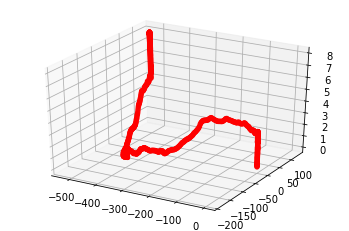

In [50]:
data = kal.muSave
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0,:], data[1,:], data[2,:], c='red')
plt.show()

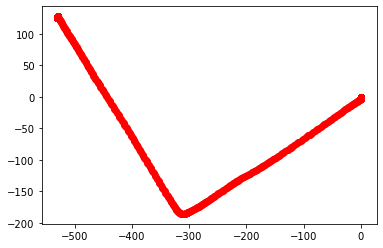

In [51]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.show()